In [1]:
%load_ext autoreload
%autoreload 2

#per la riproducibilità
%env CUBLAS_WORKSPACE_CONFIG=":4096:8"

import os
import itertools
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from IPython.display import Markdown as md
from multiprocessing import Pool
import time
from tqdm import tqdm
import networkx as nx
from networkx import stochastic_block_model


from graph_generation import GenerateGraph, perturb_nx_graph
from models import GCN, view_parameters, new_parameters, modify_parameters, Inits, new_parameters_linears
from train import Trainer, Dataset
from embedding import Embedding
from config_valid import Config, TrainingMode
import experiments
from experiments import Experiments, experiment_node_embedding, all_seeds
from plot_funcs import (plot_dim1, plot_dimN, plot_correlation_error, plot_metrics, plot_node_emb_1D, plot_node_emb_nD, scatter_node_emb, 
                        plot_graph_emb_1D, plot_graph_emb_nD, plot_data_degree_sequence, plot_corr_epoch, plot_ripetizioni_stesso_trial, 
                        plot_onlyloss_ripetizioni_stesso_trial,plot_onlyloss_ripetizioni_stesso_trial_superimposed, Data2Plot, plot_weights_multiple_hist)
from plot_model import plot_model
from utils import array_wo_outliers, plot_grafo, plot_grafo2
from Inspect import Inspect


import torch
from torch_geometric import nn
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from scipy import stats
from sklearn.metrics import log_loss

import pickle 
from plt_parameters import init_params, get_colors_to_cycle_rainbow8, get_colors_to_cycle_rainbowN
init_params()
rootsave = Path("output_plots/")

def make_video_parallel_static():
    experiments.graph_embedding_per_epoch = xp.trainer.graph_embedding_per_epoch
    experiments.node_embedding_per_epoch = xp.trainer.node_embedding_per_epoch
    experiments.dataset = xp.trainer.dataset
    experiments.loss_list = xp.trainer.test_loss_list
    experiments.exp_config = xp.trainer.config_class
    experiments.dataset_type = xp.trainer.gg.graphtype
    num_emb_neurons = xp.trainer.model.convs[-1].out_channels
    experiments.trainmode = xp.trainer.config_class.modo
    #experiments.num_classes = xp.trainer.config_class.num_classes
    experiments.embedding_dimension = num_emb_neurons
    #my_list = my_log_lista=list(range(20)) + list(range(20,100,4)) + list(range(100,500, 15)) + list(range(500, 5000, 40))
    nomefile = xp.make_video(skip=1, fromfiles=True, custom_list=True, seq_colors=True)
    return nomefile

#def run_grid(xp):
#    k = 0
#    for c in xp.gc.configs:  
#        print(f'Run {k + 1}\t\t exp name: {c.unique_train_name}')
#        # all_seeds()
#        xp.trainer.reinit_conf(c)
#        xp.just_train()
#        embedding_class = xp.embedding()
#        num_emb_neurons = xp.trainer.model.convs[-1].out_channels
#        trainmode = xp.trainer.config_class.modo        
#        embedding_class.get_metrics(num_emb_neurons, trainmode)
#        plot_metrics(embedding_class, num_emb_neurons, trainmode, sequential_colors=True)
#        k += 1

def run_grid_w_gif(xp):
    nomifilesgif = []
    k = 0
    for c in xp.gc.configs:  
        print(f'Run {k + 1}\t\t exp name: {c.unique_train_name}')
        # all_seeds()
        xp.trainer.reinit_conf(c)
        xp.just_train()
        embedding_class = xp.embedding()
        num_emb_neurons = xp.trainer.model.convs[-1].out_channels
        trainmode = xp.trainer.config_class.modo
        embedding_class.get_metrics(num_emb_neurons, trainmode)    
        nomefile = make_video_parallel_static()
        nomifilesgif.append(nomefile)
        k += 1
    return nomifilesgif

env: CUBLAS_WORKSPACE_CONFIG=":4096:8"


In [9]:
config_file = "configurations/Final1.yml"
num_nodi = 450
c = Config(config_file)
diz_trials = {'graph_dataset.ERmodel': [False], 'graph_dataset.confmodel': [False], 'graph_dataset.sbm': [True],
              'graph_dataset.Num_nodes': #[num_nodi, [num_nodi]*10,
                                          [[num_nodi]*2], 
              #'graph_dataset.list_exponents': [[-1.9, -2.0]],
             'model.GCNneurons_per_layer': [[1, 32, 1] ,[1, 32, 2] 
                                            #[1, 32, len(c.conf['graph_dataset']['list_exponents'])],
                                            #[1, 32, len(c.conf['graph_dataset']['list_p'])],
                                            #[1, 32, len(c.conf['graph_dataset']['community_probs'])],
                                           ],
              'model.neurons_last_linear':[#[16, 16, len(c.conf['graph_dataset']['list_exponents'])], 
                                           #[16, 16, len(c.conf['graph_dataset']['list_p'])],
                                          [16, 16, len(c.conf['graph_dataset']['community_probs'])]],
             'model.init_weights': ['xavier_normal', 'eye'],
             'model.freezeGCNlayers': [True],
             'model.last_layer_dense': [True]} # il layer dense false lo devo mettere in un altro grid perché non riesco a eliminare le combinazioni non volute, perché non hanno nulla di inconsistente}

xp = Experiments(config_file, diz_trials=diz_trials, rootsave=rootsave)#, config_class=c)

0 configurazioni saltate su 4, farò i seguenti 4 training:
GraphType.SBM_Classi3_nodi450_grafiXtipo40_mode1_layers§1-32-1+16-16-3§_initw-xavier_normal_lr0.01_GCNfreezedTrue
GraphType.SBM_Classi3_nodi450_grafiXtipo40_mode1_layers§1-32-1+16-16-3§_initw-eye_lr0.01_GCNfreezedTrue
GraphType.SBM_Classi3_nodi450_grafiXtipo40_mode1_layers§1-32-2+16-16-3§_initw-xavier_normal_lr0.01_GCNfreezedTrue
GraphType.SBM_Classi3_nodi450_grafiXtipo40_mode1_layers§1-32-2+16-16-3§_initw-eye_lr0.01_GCNfreezedTrue


In [ ]:
run_grid_w_gif(xp)

# Senza Layer Linear 
non mi serve fare l'animazione quando la dimensione di embedding è > 2 perché l'embedding può essere solo plottato tramite Umap, 
ma se ho la dimensionalità non ha senso neanche tentare di vedere cosa fa, anche perché umap ha poca consequenzialità nelle epoche.
Posso far vedere il calcolo delle distanze e dell'overlap

In [2]:
config_file = "configurations/Final1.yml"
num_nodi = 450
c = Config(config_file)
diz_trials = {'graph_dataset.ERmodel': [True, False], 'graph_dataset.confmodel': [True, False], 'graph_dataset.sbm': [True, False],
              'graph_dataset.Num_nodes': [num_nodi, [num_nodi]*10, [num_nodi]*2],  # per lo SBM: num nodi * num comunità 
              #'graph_dataset.list_exponents': [[-1.9, -2.0]],
             'model.GCNneurons_per_layer': [[1, 32, len(c.conf['graph_dataset']['list_exponents'])],
                                            [1, 32, len(c.conf['graph_dataset']['list_p'])],
                                            [1, 32, len(c.conf['graph_dataset']['community_probs'])],
                                           ],
             'model.init_weights': ['xavier_normal', 'eye'],
             'model.freezeGCNlayers': [False],
             'model.last_layer_dense': [False]} # il layer dense false lo devo mettere in un altro grid perché non riesco a eliminare le combinazioni non volute, perché non hanno nulla di inconsistente}

xp = Experiments(config_file, diz_trials=diz_trials, rootsave=rootsave)#, config_class=c)

138 configurazioni saltate su 144, farò i seguenti 6 training:
GraphType.ER_Classi5_nodi450_grafiXtipo40_mode1_layers§1-32-5§_initw-xavier_normal_lr0.01_GCNfreezedFalse
GraphType.ER_Classi5_nodi450_grafiXtipo40_mode1_layers§1-32-5§_initw-eye_lr0.01_GCNfreezedFalse
GraphType.CM_Classi10_nodi450_grafiXtipo40_mode1_layers§1-32-10§_initw-xavier_normal_lr0.01_GCNfreezedFalse
GraphType.CM_Classi10_nodi450_grafiXtipo40_mode1_layers§1-32-10§_initw-eye_lr0.01_GCNfreezedFalse
GraphType.SBM_Classi3_nodi450_grafiXtipo40_mode1_layers§1-32-3§_initw-xavier_normal_lr0.01_GCNfreezedFalse
GraphType.SBM_Classi3_nodi450_grafiXtipo40_mode1_layers§1-32-3§_initw-eye_lr0.01_GCNfreezedFalse


# TODO:  calcolare le dimensions per ogni epoca prima di lanciare plot_metrics (e anche le correlations..ma ce l'avevo già)  
e sostituire nel graph embedding il plot delle distanze con l'overlap come textbox nel grafico, o come titolo

In [3]:
#xp.gc.configs = xp.gc.configs[4:]

Run 1 		 exp name: GraphType.ER_Classi5_nodi450_grafiXtipo40_mode1_layers§1-32-5§_initw-xavier_normal_lr0.01_GCNfreezedFalse
Num nodi conf: 450
Generating dataset...
Mean connectivity for each node: 134.674 p=0.3
Mean connectivity for each node: 89.701 p=0.2
Mean connectivity for each node: 44.94 p=0.1
Mean connectivity for each node: 22.462 p=0.05
Mean connectivity for each node: 4.511 p=0.01
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████| 200/200 [00:23<00:00,  8.47it/s]


Tempo impiegato: 23.662819385528564


100%|█████████████████████████████████████████████████████████████████| 3000/3000 [09:16<00:00,  5.39it/s]

test accuracy finale: 1.0


Plotting 2D or n>=2 embeddings...


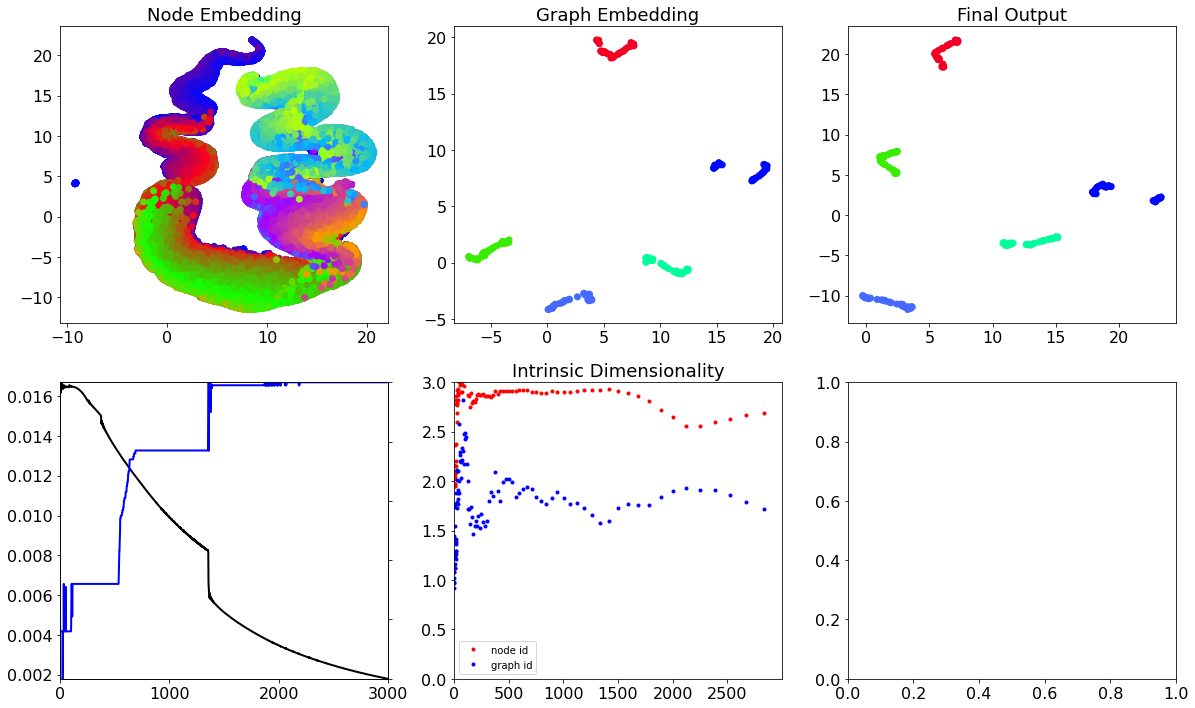

Run 2 		 exp name: GraphType.ER_Classi5_nodi450_grafiXtipo40_mode1_layers§1-32-5§_initw-eye_lr0.01_GCNfreezedFalse
Num nodi conf: 450
Generating dataset...
Mean connectivity for each node: 134.555 p=0.3
Mean connectivity for each node: 89.793 p=0.2
Mean connectivity for each node: 44.891 p=0.1
Mean connectivity for each node: 22.397 p=0.05
Mean connectivity for each node: 4.495 p=0.01
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████| 200/200 [00:23<00:00,  8.58it/s]


Tempo impiegato: 23.368290424346924


100%|█████████████████████████████████████████████████████████████████| 3000/3000 [09:36<00:00,  5.20it/s]

test accuracy finale: 0.38


Plotting 2D or n>=2 embeddings...


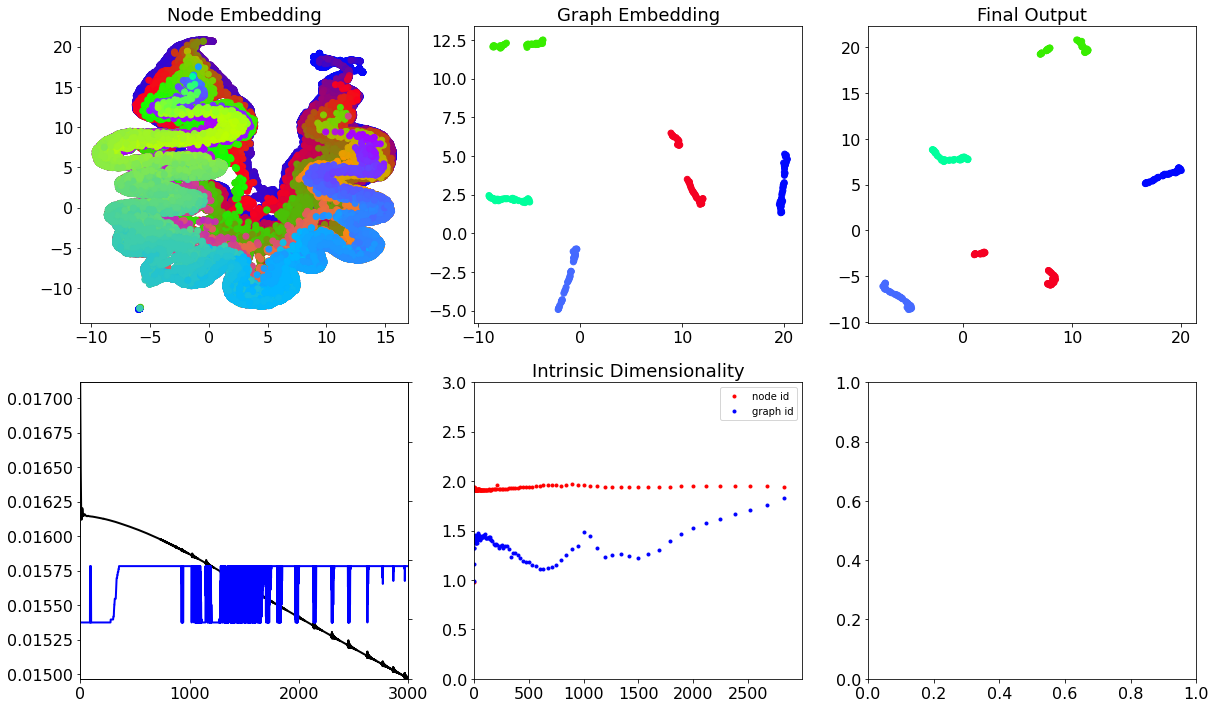

Run 3 		 exp name: GraphType.CM_Classi10_nodi450_grafiXtipo40_mode1_layers§1-32-10§_initw-xavier_normal_lr0.01_GCNfreezedFalse
Num nodi conf: [450, 450, 450, 450, 450, 450, 450, 450, 450, 450]
Generating dataset...
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████| 400/400 [00:12<00:00, 30.89it/s]


Tempo impiegato: 14.269575595855713


100%|█████████████████████████████████████████████████████████████████| 3000/3000 [13:59<00:00,  3.57it/s]


test accuracy finale: 0.83
Plotting 2D or n>=2 embeddings...


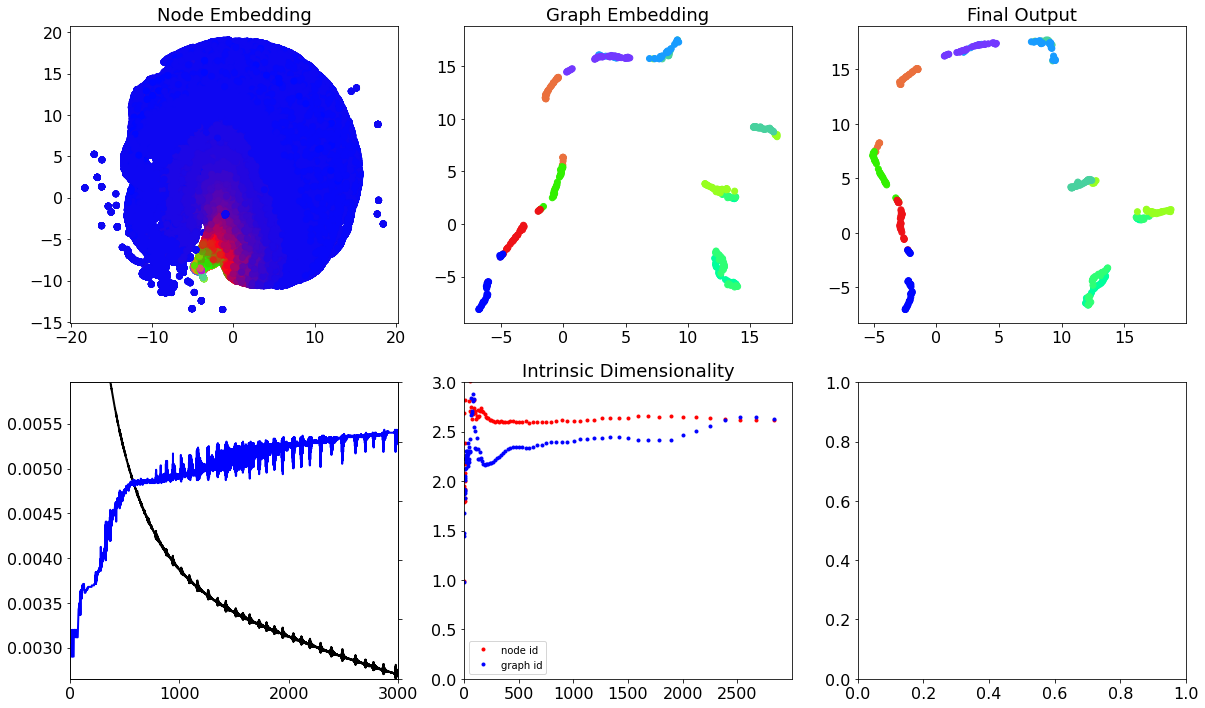

Run 4 		 exp name: GraphType.CM_Classi10_nodi450_grafiXtipo40_mode1_layers§1-32-10§_initw-eye_lr0.01_GCNfreezedFalse
Num nodi conf: [450, 450, 450, 450, 450, 450, 450, 450, 450, 450]
Generating dataset...
Dataset generated
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████| 400/400 [00:11<00:00, 35.50it/s]


Tempo impiegato: 13.644813776016235


 98%|███████████████████████████████████████████████████████████████▊ | 2944/3000 [18:20<00:24,  2.29it/s]

In [ ]:
xp.GS_simple_experiments()

### TODO:
graph correlation in CM?


### da salvare

# messaggio:
com'è l'embedding della GNN?
0) show dei plot base, correlazione, intrinsic dim (paper explanation)
1) senza Linear, l'embedding si modifica
2) con linear, che serve a sfruttare l'embedding per il downstream task, l'embedding può modificarsi di meno (correlaz e id)
3) learning rate molto basso per vedere che in partenza l'embedding ha id come vogliasmo
4) freezed per dimostrare che l'emedding di partenza come vogliamo è sufficianete per i task
5) task di autoencoder che geenralizza il task di apprendimento poiché è unsupervised, ovvero lasciamo fare alla rete senza imporre cosa deve imparare
(per esempio se facessimo node classification, l'embedding sarebbe trasformato esattamente come vorremo noi)